## Clustering Using Pyspark

For this project we will attempt to use KMeans Clustering to cluster Mall customer dataset.
We will make segmentation of those customers.

We will try 2 scenario to make cluster:
1. Include OneHotEncoder process
2. Exclude OneHotEncoder process

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Pyspark Initializasing

In [2]:
!pip install findspark
!pip install pyspark

In [3]:
# to make pyspark importable as a regular library
import findspark
findspark.init()

import pyspark

from pyspark import SparkContext
sc = SparkContext.getOrCreate()

#initializasing SparkSession for creating Spark DataFrame
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

### Load Libraries

In [4]:
# Data Frame spark profiling
from pyspark.sql.types import IntegerType, StringType, DoubleType, ShortType, DecimalType
import pyspark.sql.functions as func
from pyspark.sql.functions import isnull
from pyspark.sql.functions import isnan, when, count, col, round
from pyspark.sql.functions import mean
from pyspark.sql.types import Row
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf


# Pandas DF operation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array

# Modeling + Evaluation
from pyspark.ml.feature import VectorAssembler, VectorIndexer, OneHotEncoder, StringIndexer
from pyspark.sql.functions import when
from pyspark.sql import functions as F
from pyspark.sql.functions import avg
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler
from mpl_toolkits.mplot3d import Axes3D


### Load Data to Spark DataFrame

In [5]:
#Initializing File Type
file_type = 'text'
path= '/content/drive/MyDrive/merged_data.csv'
delimeter=','

In [6]:
def load_data(file_type):
    """input type of file "text" or "parquet" and Return pyspark dataframe"""
    if file_type =="text": # use text as file type input
        df = spark.read.option("header", "true") \
        .option("delimeter",delimeter)\
        .option("inferSchema", "true") \
        .csv(path)
    else:
        df= spark.read.parquet("example.parquet") #path file that you want import
    return df

In [7]:
df = load_data(file_type)

In [8]:
help(load_data)

Help on function load_data in module __main__:

load_data(file_type)
    input type of file "text" or "parquet" and Return pyspark dataframe



### Check Data

In [9]:
type(df)

pyspark.sql.dataframe.DataFrame

In [10]:
#show 5 observation in DataFrame
df.show(15)

+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+--------------------+------------------------+--------------------+--------------+-------------+--------------------+--------------------+-------------------+------+-------------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+------------------+------------+--------------------+-------------+--------------------+------------+--------------------+----------------------+--------------------+-----------------------+----------------------+--------------------+------------+-----------------------------+
|            order_id|         customer_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|  cus

In [11]:
#Print Schema
df.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: string (nullable = true)
 |-- order_approved_at: string (nullable = true)
 |-- order_delivered_carrier_date: string (nullable = true)
 |-- order_delivered_customer_date: string (nullable = true)
 |-- order_estimated_delivery_date: string (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_zip_code_prefix: string (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = true)
 |-- order_item_id: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: timestamp (nullable = true)
 |-- price: double (nullable = true)
 |-- freight_value: double (nullable = true)
 |-- product_category_name: string (nullable = true)
 |-- product_name_lenght: double (nullable = true)
 |-- product_de

In [12]:
len(df.columns), df.columns

(40,
 ['order_id',
  'customer_id',
  'order_status',
  'order_purchase_timestamp',
  'order_approved_at',
  'order_delivered_carrier_date',
  'order_delivered_customer_date',
  'order_estimated_delivery_date',
  'customer_unique_id',
  'customer_zip_code_prefix',
  'customer_city',
  'customer_state',
  'order_item_id',
  'product_id',
  'seller_id',
  'shipping_limit_date',
  'price',
  'freight_value',
  'product_category_name',
  'product_name_lenght',
  'product_description_lenght',
  'product_photos_qty',
  'product_weight_g',
  'product_length_cm',
  'product_height_cm',
  'product_width_cm',
  'payment_sequential',
  'payment_type',
  'payment_installments',
  'payment_value',
  'review_id',
  'review_score',
  'review_comment_title',
  'review_comment_message',
  'review_creation_date',
  'review_answer_timestamp',
  'seller_zip_code_prefix',
  'seller_city',
  'seller_state',
  'product_category_name_english'])

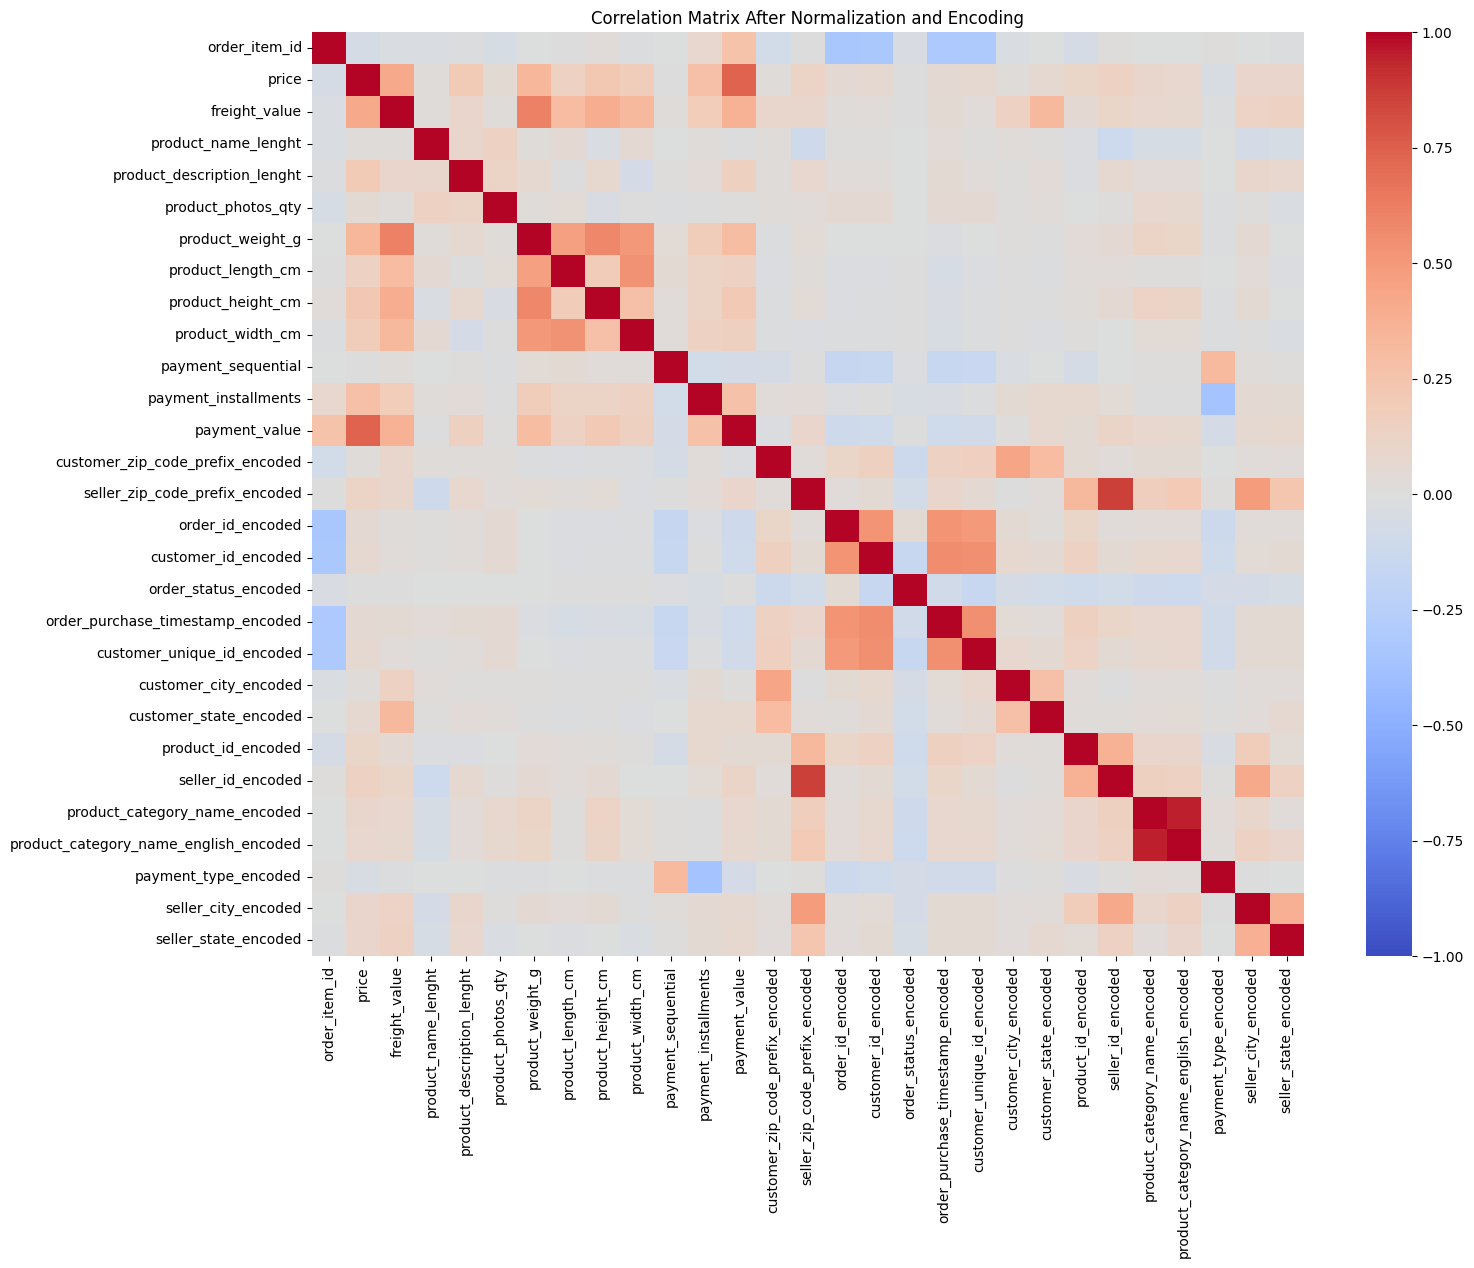

Unique Values in Encoded Columns:
customer_zip_code_prefix_encoded: 14990
seller_zip_code_prefix_encoded: 2290
order_id_encoded: 103196
customer_id_encoded: 99725
order_status_encoded: 2420
order_purchase_timestamp_encoded: 99215
customer_unique_id_encoded: 95455
customer_city_encoded: 4116
customer_state_encoded: 27
product_id_encoded: 32952
seller_id_encoded: 3096
product_category_name_encoded: 73
product_category_name_english_encoded: 90
payment_type_encoded: 4
seller_city_encoded: 660
seller_state_encoded: 62
                                     scaled_features
0  [-0.2733081005532834, -0.5051972960204306, -0....
1  [-0.2733081005532834, -0.5051972960204306, -0....
2  [-0.2733081005532834, -0.5051972960204306, -0....
3  [-0.2733081005532834, -0.01085819592818115, 0....
4  [-0.2733081005532834, 0.21873002325568403, -0....


In [19]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.stat import Correlation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Drop unnecessary columns
columns_to_drop = [
    'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date',
    'order_estimated_delivery_date', 'shipping_limit_date', 'review_id', 'review_score',
    'review_comment_title', 'review_comment_message', 'review_creation_date',
    'review_answer_timestamp'
]
merged_dataset = df.drop(*columns_to_drop)

# Define numerical and categorical columns
numerical_columns = [
    'order_item_id', 'price', 'freight_value',
    'product_name_lenght', 'product_description_lenght', 'product_photos_qty',
    'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm',
    'payment_sequential', 'payment_installments', 'payment_value'
]

categorical_columns = [
    'customer_zip_code_prefix', 'seller_zip_code_prefix',  # Handle these separately if needed
    'order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
    'customer_unique_id', 'customer_city', 'customer_state', 'product_id',
    'seller_id', 'product_category_name', 'product_category_name_english',
    'payment_type', 'seller_city', 'seller_state'
]

# Fill missing values in numerical columns with the mean
for col in numerical_columns:
    mean_value = merged_dataset.agg({col: "mean"}).collect()[0][0]
    merged_dataset = merged_dataset.fillna({col: mean_value})

# Fill missing values in categorical columns with the mode
for col in categorical_columns:
    mode_value = (
        merged_dataset.groupBy(col)
        .count()
        .orderBy(F.desc("count"))
        .first()
    )
    if mode_value and mode_value[0] is not None:
        mode_value = mode_value[0]
    else:
        mode_value = "Unknown"  # Default fallback for missing mode
    merged_dataset = merged_dataset.fillna({col: mode_value})

# Step 1: Label encoding for categorical columns
for col in categorical_columns:
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_encoded", handleInvalid="keep")
    merged_dataset = indexer.fit(merged_dataset).transform(merged_dataset)

# Rename encoded columns
encoded_columns = [f"{col}_encoded" for col in categorical_columns]
merged_dataset = merged_dataset.drop(*categorical_columns)

# Step 2: Assemble numerical and encoded features into a single vector column
all_features = numerical_columns + encoded_columns
assembler = VectorAssembler(inputCols=all_features, outputCol="features")
merged_dataset = assembler.transform(merged_dataset)

# Step 3: Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
merged_dataset = scaler.fit(merged_dataset).transform(merged_dataset)

# Step 4: Compute the correlation matrix
correlation_matrix = Correlation.corr(merged_dataset, "scaled_features").head()[0]
correlation_matrix = correlation_matrix.toArray()

# Convert the correlation matrix to a Pandas DataFrame for visualization
correlation_df = pd.DataFrame(correlation_matrix, columns=all_features, index=all_features)

# Plot the correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_df, annot=False, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix After Normalization and Encoding")
plt.show()

# Check column counts for validation
print("Unique Values in Encoded Columns:")
for col in encoded_columns:
    print(f"{col}: {merged_dataset.select(col).distinct().count()}")

# Convert PySpark DataFrame to Pandas for inspection (optional)
scaled_pandas_df = merged_dataset.select("scaled_features").toPandas()
print(scaled_pandas_df.head())


### Modelling

#### Optimize choice of k

One disadvantage of KMeans is that the algortihm must told how many cluster - k- that should try to find. To optimize of k, we group fraction of the data for different k and look for an "elbow" in the cost function. Then, we plot the "elbow".

In [23]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from sklearn.metrics import adjusted_rand_score, davies_bouldin_score

# Step 1: Remove existing conflicting columns
columns_to_remove = ["features", "scaled_features", "price_bins"]
for col in columns_to_remove:
    if col in merged_dataset.columns:
        merged_dataset = merged_dataset.drop(col)

# Step 2: Assemble feature columns
feature_columns = [col for col in merged_dataset.columns if col not in ['customer_id', 'price']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
merged_dataset = assembler.transform(merged_dataset)

# Step 3: Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
merged_dataset = scaler.fit(merged_dataset).transform(merged_dataset)

# Step 4: Apply KMeans clustering
kmeans = KMeans(k=2, seed=42, featuresCol="scaled_features", predictionCol="cluster")
kmeans_model = kmeans.fit(merged_dataset)

# Step 5: Assign clusters to the dataset
clustered_data = kmeans_model.transform(merged_dataset)

# Show cluster assignments
clustered_data.select("scaled_features", "cluster").show(5)

# Cluster centers
print("Cluster Centers:")
for center in kmeans_model.clusterCenters():
    print(center)

# Step 6: Evaluate clustering with Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="scaled_features", predictionCol="cluster", metricName="silhouette")
silhouette_score = evaluator.evaluate(clustered_data)
print(f"Silhouette Score: {silhouette_score}")

# Step 7: Adjusted Rand Index (ARI)
# Discretize the 'price' column into bins
median_price = clustered_data.approxQuantile("price", [0.5], 0.0)[0]  # Median price
clustered_data = clustered_data.withColumn(
    "price_bins", F.when(F.col("price") < median_price, 0).otherwise(1)
)

# Convert Spark DataFrame to Pandas for ARI computation
pandas_data = clustered_data.select("price_bins", "cluster").toPandas()
ari_score = adjusted_rand_score(pandas_data["price_bins"], pandas_data["cluster"])
print(f"Adjusted Rand Index (ARI): {ari_score}")

# Step 8: Davies-Bouldin Index
# Extract scaled features as a NumPy array
scaled_features = clustered_data.select("scaled_features").rdd.map(lambda x: x[0].toArray()).collect()
dbi_score = davies_bouldin_score(scaled_features, pandas_data["cluster"])
print(f"Davies-Bouldin Index: {dbi_score}")


+--------------------+-------+
|     scaled_features|cluster|
+--------------------+-------+
|[1.46388520731184...|      1|
|[1.46388520731184...|      1|
|[1.46388520731184...|      1|
|[1.46388520731184...|      0|
|[1.46388520731184...|      0|
+--------------------+-------+
only showing top 5 rows

Cluster Centers:
[1.46395467e+00 1.32286883e+00 5.03555403e+00 1.27442879e+00
 1.37850993e+00 5.72442806e-01 1.89940329e+00 1.25503714e+00
 2.00456622e+00 1.40879157e+00 1.06291114e+00 5.79581420e-01
 1.09324904e+00 7.04925924e-01 1.82909203e+00 1.80845798e+00
 3.17434515e-03 1.79047542e+00 1.73262070e+00 5.26380535e-01
 6.87123773e-01 8.69693326e-01 7.12547795e-01 9.17671415e-01
 9.70754168e-01 4.30695266e-01 5.71514654e-01 4.48983930e-01]
[2.30963219 1.24528195 4.99728282 1.18231626 1.21891024 0.57213327
 1.95748749 1.29363341 2.03724695 1.79439997 1.07429223 0.83732323
 0.66728516 0.54276435 0.33430018 0.19175254 0.38855984 0.20986125
 0.17607666 0.31958073 0.53341004 0.48589191 0.559

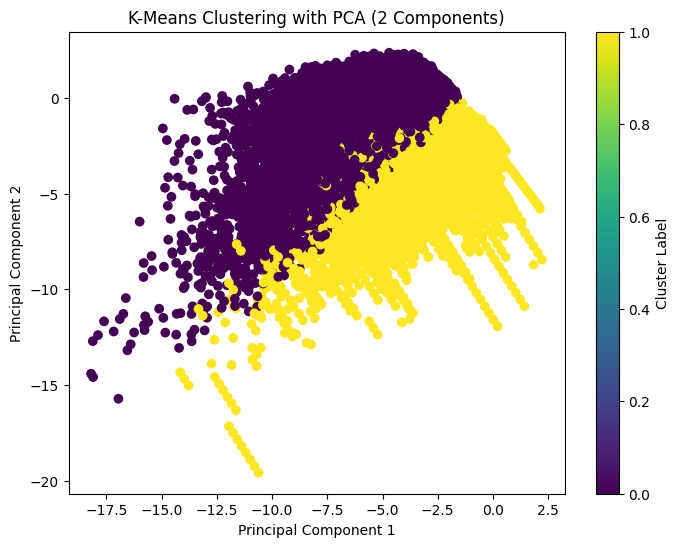

In [25]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import PCA as SparkPCA, VectorAssembler, StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Ensure scaled features exist in the dataset
if "scaled_features" not in merged_dataset.columns:
    feature_columns = [col for col in merged_dataset.columns if col not in ['customer_id', 'price']]
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    merged_dataset = assembler.transform(merged_dataset)

    scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
    merged_dataset = scaler.fit(merged_dataset).transform(merged_dataset)

# Step 2: Apply KMeans clustering to assign clusters
kmeans = KMeans(k=2, seed=42, featuresCol="scaled_features", predictionCol="cluster")
kmeans_model = kmeans.fit(merged_dataset)
clustered_data = kmeans_model.transform(merged_dataset)

# Step 3: Apply PCA in PySpark to reduce dimensions to 2
spark_pca = SparkPCA(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = spark_pca.fit(clustered_data)
pca_result = pca_model.transform(clustered_data)

# Step 4: Convert PCA results and cluster labels to Pandas DataFrame for visualization
pandas_data = pca_result.select("pca_features", "cluster").toPandas()
pandas_data[["PCA1", "PCA2"]] = pandas_data["pca_features"].apply(
    lambda vec: pd.Series(vec.toArray())
)
clusters = pandas_data["cluster"]

# Step 5: Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pandas_data["PCA1"], pandas_data["PCA2"], c=clusters, cmap="viridis", marker="o")
plt.title("K-Means Clustering with PCA (2 Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster Label")
plt.show()


In [26]:
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from sklearn.metrics import adjusted_rand_score, davies_bouldin_score

# Step 1: Remove existing conflicting columns
columns_to_remove = ["features", "scaled_features", "price_bins"]
for col in columns_to_remove:
    if col in merged_dataset.columns:
        merged_dataset = merged_dataset.drop(col)

# Step 2: Assemble feature columns
feature_columns = [col for col in merged_dataset.columns if col not in ['customer_id', 'price']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
merged_dataset = assembler.transform(merged_dataset)

# Step 3: Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
merged_dataset = scaler.fit(merged_dataset).transform(merged_dataset)

# Step 4: Apply GMM clustering
gmm = GaussianMixture(k=2, seed=42, featuresCol="scaled_features", predictionCol="cluster")
gmm_model = gmm.fit(merged_dataset)

# Step 5: Assign clusters to the dataset
clustered_data = gmm_model.transform(merged_dataset)

# Show cluster assignments
clustered_data.select("scaled_features", "cluster").show(5)

# Cluster centers (means of Gaussian distributions)
print("Cluster Means:")
for mean in gmm_model.gaussiansDF.collect():
    print(mean["mean"])

# Step 6: Evaluate clustering with Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="scaled_features", predictionCol="cluster", metricName="silhouette")
silhouette_score = evaluator.evaluate(clustered_data)
print(f"Silhouette Score: {silhouette_score}")

# Step 7: Adjusted Rand Index (ARI)
# Discretize the 'price' column into bins
median_price = clustered_data.approxQuantile("price", [0.5], 0.0)[0]  # Median price
clustered_data = clustered_data.withColumn(
    "price_bins", F.when(F.col("price") < median_price, 0).otherwise(1)
)

# Convert Spark DataFrame to Pandas for ARI computation
pandas_data = clustered_data.select("price_bins", "cluster").toPandas()
ari_score = adjusted_rand_score(pandas_data["price_bins"], pandas_data["cluster"])
print(f"Adjusted Rand Index (ARI): {ari_score}")

# Step 8: Davies-Bouldin Index
# Extract scaled features as a NumPy array
scaled_features = clustered_data.select("scaled_features").rdd.map(lambda x: x[0].toArray()).collect()
dbi_score = davies_bouldin_score(scaled_features, pandas_data["cluster"])
print(f"Davies-Bouldin Index: {dbi_score}")


+--------------------+-------+
|     scaled_features|cluster|
+--------------------+-------+
|[1.46388520731184...|      1|
|[1.46388520731184...|      1|
|[1.46388520731184...|      1|
|[1.46388520731184...|      1|
|[1.46388520731184...|      1|
+--------------------+-------+
only showing top 5 rows

Cluster Means:
[1.942598832284892,1.8153861045573516,4.93366211947693,1.5551225364958514,1.4923676413910874,1.065863405620088,2.313732975156599,1.6336271311199966,2.2913368751833585,1.7094239994347917,1.2645748775216799,1.040655716246276,1.194473427518193,1.1218562106906877,1.347129065334089,1.256575725851119,0.3692844770057217,1.2770731487320905,1.1966886281686149,0.7761812639296068,0.9373009441776893,1.0344441366164785,1.2425855631044618,1.2128879966860457,1.199947672830062,0.7052409665610038,0.9082805202623832,0.7108240687175567]
[1.701423379455135,1.2076665876697195,5.0387790016229035,1.1906035966096944,1.298135723784744,0.48639965063560925,1.849285849761549,1.2037504642668626,1.9670

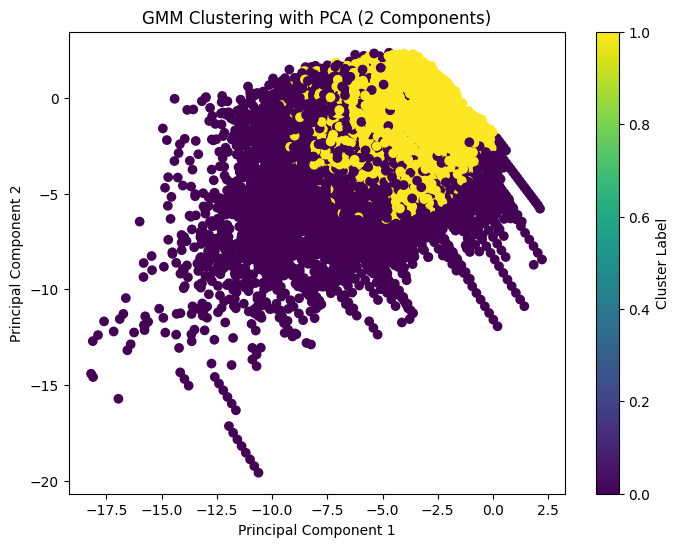

In [27]:
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.feature import PCA as SparkPCA, VectorAssembler, StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Ensure scaled features exist in the dataset
if "scaled_features" not in merged_dataset.columns:
    feature_columns = [col for col in merged_dataset.columns if col not in ['customer_id', 'price']]
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    merged_dataset = assembler.transform(merged_dataset)

    scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
    merged_dataset = scaler.fit(merged_dataset).transform(merged_dataset)

# Step 2: Apply GMM clustering to assign clusters
gmm = GaussianMixture(k=2, seed=42, featuresCol="scaled_features", predictionCol="cluster")
gmm_model = gmm.fit(merged_dataset)
clustered_data = gmm_model.transform(merged_dataset)

# Step 3: Apply PCA in PySpark to reduce dimensions to 2
spark_pca = SparkPCA(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = spark_pca.fit(clustered_data)
pca_result = pca_model.transform(clustered_data)

# Step 4: Convert PCA results and cluster labels to Pandas DataFrame for visualization
pandas_data = pca_result.select("pca_features", "cluster").toPandas()
pandas_data[["PCA1", "PCA2"]] = pandas_data["pca_features"].apply(
    lambda vec: pd.Series(vec.toArray())
)
clusters = pandas_data["cluster"]

# Step 5: Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pandas_data["PCA1"], pandas_data["PCA2"], c=clusters, cmap="viridis", marker="o")
plt.title("GMM Clustering with PCA (2 Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster Label")
plt.show()


In [28]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
import pyspark.sql.functions as F
from sklearn.metrics import adjusted_rand_score, davies_bouldin_score

# Step 1: Remove existing conflicting columns
columns_to_remove = ["features", "scaled_features", "price_bins"]
for col in columns_to_remove:
    if col in merged_dataset.columns:
        merged_dataset = merged_dataset.drop(col)

# Step 2: Assemble feature columns
feature_columns = [col for col in merged_dataset.columns if col not in ['customer_id', 'price']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
merged_dataset = assembler.transform(merged_dataset)

# Step 3: Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
merged_dataset = scaler.fit(merged_dataset).transform(merged_dataset)

# Step 4: Apply KMeans++ clustering
kmeans = KMeans(
    k=2,  # Number of clusters
    seed=42,  # Seed for reproducibility
    featuresCol="scaled_features",
    predictionCol="cluster",
    initMode="k-means||"  # KMeans++ initialization
)
kmeans_model = kmeans.fit(merged_dataset)

# Step 5: Assign clusters to the dataset
clustered_data = kmeans_model.transform(merged_dataset)

# Show cluster assignments
clustered_data.select("scaled_features", "cluster").show(5)

# Cluster centers
print("Cluster Centers:")
for center in kmeans_model.clusterCenters():
    print(center)

# Step 6: Evaluate clustering with Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="scaled_features", predictionCol="cluster", metricName="silhouette")
silhouette_score = evaluator.evaluate(clustered_data)
print(f"Silhouette Score: {silhouette_score}")

# Step 7: Adjusted Rand Index (ARI)
# Discretize the 'price' column into bins
median_price = clustered_data.approxQuantile("price", [0.5], 0.0)[0]  # Median price
clustered_data = clustered_data.withColumn(
    "price_bins", F.when(F.col("price") < median_price, 0).otherwise(1)
)

# Convert Spark DataFrame to Pandas for ARI computation
pandas_data = clustered_data.select("price_bins", "cluster").toPandas()
ari_score = adjusted_rand_score(pandas_data["price_bins"], pandas_data["cluster"])
print(f"Adjusted Rand Index (ARI): {ari_score}")

# Step 8: Davies-Bouldin Index
# Extract scaled features as a NumPy array
scaled_features = clustered_data.select("scaled_features").rdd.map(lambda x: x[0].toArray()).collect()
dbi_score = davies_bouldin_score(scaled_features, pandas_data["cluster"])
print(f"Davies-Bouldin Index: {dbi_score}")


+--------------------+-------+
|     scaled_features|cluster|
+--------------------+-------+
|[1.46388520731184...|      1|
|[1.46388520731184...|      1|
|[1.46388520731184...|      1|
|[1.46388520731184...|      0|
|[1.46388520731184...|      0|
+--------------------+-------+
only showing top 5 rows

Cluster Centers:
[1.46395467e+00 1.32286883e+00 5.03555403e+00 1.27442879e+00
 1.37850993e+00 5.72442806e-01 1.89940329e+00 1.25503714e+00
 2.00456622e+00 1.40879157e+00 1.06291114e+00 5.79581420e-01
 1.09324904e+00 7.04925924e-01 1.82909203e+00 1.80845798e+00
 3.17434515e-03 1.79047542e+00 1.73262070e+00 5.26380535e-01
 6.87123773e-01 8.69693326e-01 7.12547795e-01 9.17671415e-01
 9.70754168e-01 4.30695266e-01 5.71514654e-01 4.48983930e-01]
[2.30963219 1.24528195 4.99728282 1.18231626 1.21891024 0.57213327
 1.95748749 1.29363341 2.03724695 1.79439997 1.07429223 0.83732323
 0.66728516 0.54276435 0.33430018 0.19175254 0.38855984 0.20986125
 0.17607666 0.31958073 0.53341004 0.48589191 0.559

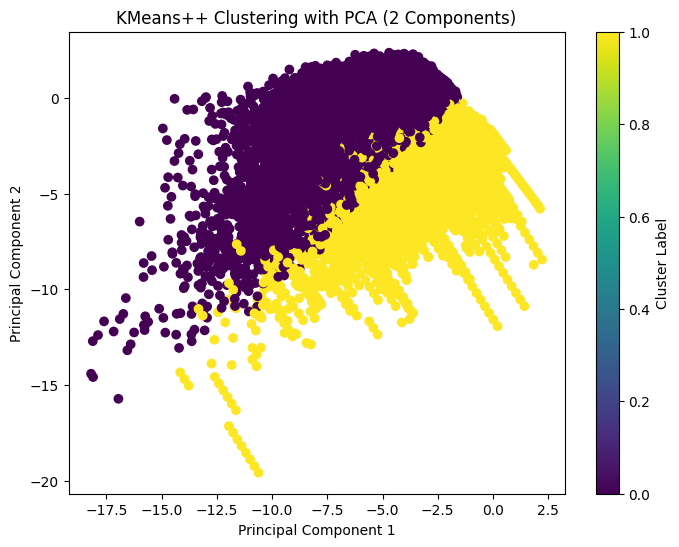

In [29]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import PCA as SparkPCA, VectorAssembler, StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Ensure scaled features exist in the dataset
if "scaled_features" not in merged_dataset.columns:
    feature_columns = [col for col in merged_dataset.columns if col not in ['customer_id', 'price']]
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    merged_dataset = assembler.transform(merged_dataset)

    scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
    merged_dataset = scaler.fit(merged_dataset).transform(merged_dataset)

# Step 2: Apply KMeans++ clustering to assign clusters
kmeans = KMeans(
    k=2,
    seed=42,
    featuresCol="scaled_features",
    predictionCol="cluster",
    initMode="k-means||"  # KMeans++ initialization
)
kmeans_model = kmeans.fit(merged_dataset)
clustered_data = kmeans_model.transform(merged_dataset)

# Step 3: Apply PCA in PySpark to reduce dimensions to 2
spark_pca = SparkPCA(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = spark_pca.fit(clustered_data)
pca_result = pca_model.transform(clustered_data)

# Step 4: Convert PCA results and cluster labels to Pandas DataFrame for visualization
pandas_data = pca_result.select("pca_features", "cluster").toPandas()
pandas_data[["PCA1", "PCA2"]] = pandas_data["pca_features"].apply(
    lambda vec: pd.Series(vec.toArray())
)
clusters = pandas_data["cluster"]

# Step 5: Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pandas_data["PCA1"], pandas_data["PCA2"], c=clusters, cmap="viridis", marker="o")
plt.title("KMeans++ Clustering with PCA (2 Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster Label")
plt.show()
